# Naive Bayes y Mixturas Gaussianas

Celdas preparatorias, como de constumbre.

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os, sys

import matplotlib.pyplot as plt
%matplotlib inline

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "08_NB-GM"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "plots", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    os.makedirs(IMAGES_PATH, exist_ok=True)
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
# import warnings
# warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Estimación ML de los parámetros de una distribución normal

Discutimos extensamente cómo obtener los parámetros de máxima verosimilitud de varios problemas (binomial, regresión lineal, etc.).

Ahora veamos con un poco más de detalle cómo se obtienen los parámetros de una multinormal, $\boldsymbol{\mu}$ (vector) y la matriz de covarianza $\Sigma$, a partir de la maximización de la verosimilitud.

Para facilitar las cosas, trabajemos en dos dimensiones.

In [6]:
# Ground truth
mu = np.array([0.0, 0.0])
cov = np.array([[1.0, 0.5], [0.5, 1.0]])

# Muestreamos una multinormal con esos parámetros
np.random.seed(20210427)
X = np.random.multivariate_normal(mean=mu, cov=cov, size=1000)

# Veamos qué nos dieron
print(X.shape)

(1000, 2)


Text(0, 0.5, '$X_2$')

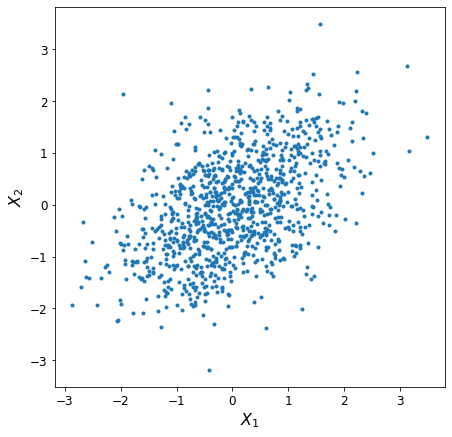

In [7]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)

# Ok, cada punto es un vector fila.
# Para que esté listo para matplotlib, hay que transponer.
ax.plot(*X.T, '.')
ax.set_xlabel('$X_1$', fontsize=16)
ax.set_ylabel('$X_2$', fontsize=16)

Nuestro juego habitual: supongamos que tenemos los datos y queremos conocer el valor del vector $\boldsymbol{\mu}$ y de la matriz de covarianza $\Sigma$.

Para lograr esto, necesitamos un criterio; una función que maximizar. La función que se impone es la verosimiltud de los datos.

Suponiendo que los datos están distribuídos como una normal y son independientes (**¡ojo! nada que ver con la independencia de los features; acá hablamos de la independencia entre cada instancia observada**), la verosimilitud se puede escribir como el producto de las verosimilitudes de cada punto. Noten que estas suposiciones acá son válidas

$$
p(\mathbf{X} | \boldsymbol{\mu}, \Sigma) = \prod_{n=1}^N \mathcal{N}(x_n | \boldsymbol{\mu}, \Sigma)\;\;.
$$

Hermoso, ahora solo queda encontrar los valores que maximizan esta expresión.

Como de costumbre, es conveniente usar el logaritmo de esta expresión, que convierte productoria en suma.

$$
\ln p(\mathbf{X} | \boldsymbol{\mu}, \Sigma) = \sum_{n=1}^N \ln \mathcal{N}(x_n | \boldsymbol{\mu}, \Sigma) = -\frac{1}{2} \sum_{n=1}^N (x_n - \boldsymbol{\mu})^T \Sigma^{-1} (x_n - \boldsymbol{\mu}) -\frac{N}{2}\left|\Sigma\right| - \frac{N D}{2}\ln(2\pi)\;\;,
$$

donde $D$ es la dimensión de los datos, y usamos la expresión típica de la normal (p.ej. Bishop, ecuación 2.43).

El último término es una constante, y podemos ignorarlo olímpicamente. 

Para avanzar, supongamos primero que solo queremos encontrar $\boldsymbol{\mu}$, pero que conocemos $\Sigma$. ¿Cómo hacemos?

### Fuerza bruta??

### Analítico

Se puede mostrar que la derivada de la ecuación de arriba se vuelve cero para 

$$
\boldsymbol{\mu}_\mathrm{ML} = \frac{1}{N}\sum_{n=1}^N x_n\;\;,
$$

como podríamos haber esperado también de la Ley de los Grandes Números.

In [8]:
# En la práctica, esto corresponde con hacer la media a lo largo de las filas
mu_ML = np.average(X, axis=0)

print(mu_ML)

[-0.00695258 -0.04909106]


Por supuesto, no es exactamente cero; estos estimadores tienen su varianza, pero vamos a ignorar eso y concentrarnos en la estimación puntual.

En este caso, es fácil ver que:

$$
\mathbb{E}\left[\boldsymbol{\mu}_\mathrm{ML}\right] = \boldsymbol{\mu}
$$

La situación con la covarianza es bastante más complicada, pero vamos a dar el resultado directo.

$$
\Sigma_\text{ML} = \frac{1}{N}\sum_{n=1}^N (x_n - \boldsymbol{\mu}_\text{ML})(x_n - \boldsymbol{\mu}_\text{ML})^T\;\;,
$$

donde tenemos el producto de un vector columna por un vector fila, lo que nos da una matriz, tal como queremos.

In [10]:
h = X - mu_ML

print(h.shape)

# Tenemos que transponer h para que tenga la forma de la ecuación de arriba
hh = h.T

# Listo, ahora la suma se hace con el producto dot y normalizamos.
sigma_ML = np.dot(hh, hh.T) / len(X)
print(sigma_ML)

(1000, 2)
[[0.97675437 0.45705449]
 [0.45705449 0.93842784]]


En este caso, se puede ver que 

$$
\mathbb{E}\left[\Sigma_\mathrm{ML}\right] = \frac{N-1}{N}{\Sigma}\;\;,
$$

por lo que conviene, para tener un estimador no sesgado, usar la definición

$$
\tilde{\Sigma} = \frac{1}{N-1}\sum_{n=1}^N (x_n - \boldsymbol{\mu}_\text{ML})(x_n - \boldsymbol{\mu}_\text{ML})^T\;\;,
$$

In [11]:
print(sigma_ML * len(X) / (len(X) - 1))

[[0.9777321  0.457512  ]
 [0.457512   0.93936721]]


## Naive Bayes

Vamos a usar las ideas de arriba para realizar un modelo de Naive Bayes usando Gaussianas. 

### Caso isotrópico

Creemos unos datos con `make_blobs`.

In [12]:
from sklearn.datasets import make_blobs

gt_center = np.array([[2.0, 2.0],[-2.0, -2.0]])
X, t = make_blobs(1000, n_features=2, centers=gt_center, cluster_std=1.5, random_state=1234, )

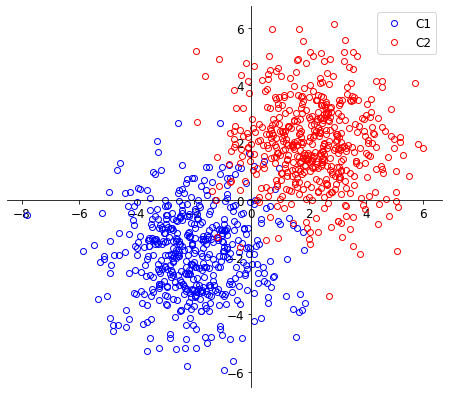

In [13]:
from utils import plot_clasi
plot_clasi(X, t, [], [], [], [], join_centers=False)

p(x_1, x_2) != p(x_1) p(x_2)

p(x_1, x_2 | C_1) = p(x_1 |C_1) p(x_2 |C_1)

El entrenamiento consiste en calcular los estimadores de máxima verosimilitud usando solo los datos de cada una de las clases.

In [14]:
# Hagamos a mano las medias
mu_c0 = np.average(X[t == 0], axis=0)
mu_c1 = np.average(X[t == 1], axis=0)

print('__Centers__ C0:', mu_c0, 'C1:', mu_c1)

__Centers__ C0: [2.09318759 1.95403416] C1: [-2.00831059 -1.86640382]


In [28]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb = gnb.fit(X, t)

# Let's see the parameters
print('Means', *gnb.theta_)
print('Sigma\n', gnb.sigma_)

Means [-1.95633307 -2.03480183] [1.92133233 1.90802866]
Sigma
 [[2.61300706 2.68648379]
 [2.27453512 2.28280613]]


In [24]:
gnb.predict_proba(X[:4])

array([[3.92123106e-01, 6.07876894e-01],
       [9.99904163e-01, 9.58367973e-05],
       [2.31824280e-04, 9.99768176e-01],
       [5.37128069e-02, 9.46287193e-01]])

In [22]:
# Let's compute performance by cross validations
from sklearn.model_selection import cross_val_score

cvs = cross_val_score(gnb, X, t, cv=5, scoring='accuracy')
print('CV accuracy {:.2f} +/- {:.2f}'.format(cvs.mean(), cvs.std()))

CV accuracy 0.95 +/- 0.01


### Caso no isotrópico

Vamos a hacerle las cosas un poco más difíciles con un dataset no tan adaptado.

In [25]:
from numpy.random import multivariate_normal

def make_dataset(mu1=[0, 0], mu2=[-4, 1.5], 
                 cov1=[[1, 0.95],[0.95, 1]], cov2=[[1, 0.8],[0.8, 1]], 
                 size1=250, size2=200, random_state=20200922):

    np.random.seed(random_state)
    # Sample classes
    xc1 = multivariate_normal(mean=mu1, cov=cov1, size=size1).T
    xc2 = multivariate_normal(mean=mu2, cov=cov2, size=size2).T

    print(xc1.shape, xc2.shape)

    # Concatenate both classes
    x = np.hstack([xc1, xc2]).T
    tc1 = np.ones(xc1.shape[1])
    tc2 = -np.ones(xc2.shape[1])
    # tc2 = -np.ones((1, xc2.shape[1]))
    t = np.hstack([tc1, tc2])
    
    # Make desing matrix adding a column of ones
    phi0 = np.ones([len(x), 1])
    phi = np.hstack([phi0, x.copy()])

    return x, t, phi

In [41]:
cov1 = np.array([[1.5**2, 1.0],[1.0, 1.5**2]])
cov2 = [[1.5**2, -2.0],[-2.0, 1.5**2]]

X, t, phi = make_dataset(mu1=gt_center[0], mu2=gt_center[1], cov1=cov1, cov2=cov2, size1=500, size2=500)

(2, 500) (2, 500)


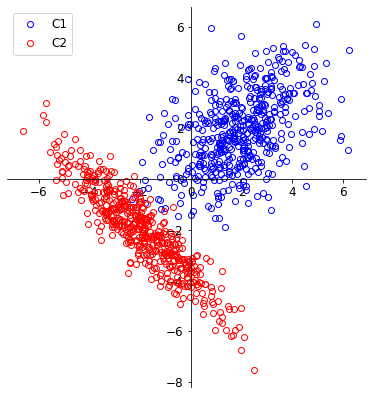

In [42]:
plot_clasi(X, t, [], [], [], [], join_centers=False)

In [43]:
# Ajustemos y evalumos por CV
gnb = gnb.fit(X, t)

cvs = cross_val_score(gnb, X, t, cv=5, scoring='accuracy')
print('CV accuracy {:.2f} +/- {:.2f}'.format(cvs.mean(), cvs.std()))

CV accuracy 0.97 +/- 0.01


In [44]:
gnb.theta_

array([[-1.95633307, -2.03480183],
       [ 1.92133233,  1.90802866]])

### Cálculo de p(x)

Una de las grandes ventajas de los modelos generativos es la posibilidad de calcular la probabilidad marginal de un dato (es decir, marginalizando sobre las clases). Para eso, usamos el teorema de Bayes.

Suponemos $p(C_1) = p(C_2) = 0.5$

$$
p(x) = \sum_{k=1}^2 p(x | C_k) p(C_k)\;\;,
$$

Entonces, podemos, dado un punto, calcular ese valor

In [45]:
import scipy.stats as st
new_x = np.array([4, 5]).reshape(1, -1)

h = [st.multivariate_normal(mean=gnb.theta_[i], cov=np.eye(2)*gnb.sigma_[i,i]).pdf(new_x) * 0.5 for i in range(2)]
print('p(x) = {:.6f}'.format(np.sum(h)))

p(x) = 0.001667


In [50]:
X_ = np.linspace(-6, 6, 500)
Y_ = np.linspace(-6, 6, 500)

XX, YY = np.meshgrid(X_, Y_)

# Prepare array
aa =np.array([XX.ravel(), YY.ravel()]).T
allZ = np.array([st.multivariate_normal(mean=gnb.theta_[i], cov=np.diag(np.diag(gnb.sigma_))).pdf(aa) * 0.5 for i in range(2)])

# Sum over classes
Z_ = np.sum(allZ, axis=0)

# Reshape
ZZ = Z_.reshape(500, 500)

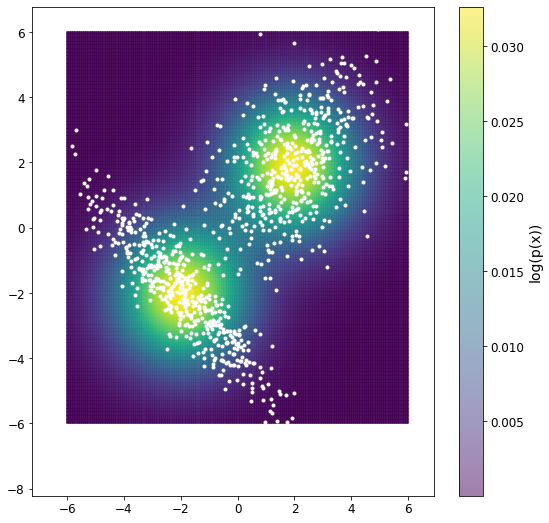

In [51]:
plt.figure(figsize=(9, 9))
plt.plot(*X.T, '.w')
plt.pcolor(XX, YY, ZZ, alpha=0.5, shading='nearest')
plt.colorbar(label='log(p(x))')

In [ ]:
gnb.predict_proba(np.array([3, -3]).reshape(1, -1))

## Mixturas Gaussianas
<a id='mixtures'></a>

### Las limitaciones de la distribución normal

Cuando estudiamos la distribución normal, vimos que uno de las ventajas de sus propiedades analíticas es que sirven como elementos de modelos más complejos. 

Una técnica para hacer esto es la mixtura de Gaussianas, que nos permite captar mucha más complejidad que una simple normal.

In [52]:
if 'google.colab' in sys.modules:
    # Si están en el colab, primero corran este código
    !mkdir datasets
    !wget https://raw.githubusercontent.com/IAI-UNSAM/datasets/master/faithful.csv
    !mv faithful.csv datasets/

Estos datos contienen información sobre la erupciones de geisers en Old Faithful, en el parque [Yellowstone](https://www.nps.gov/yell/learn/photosmultimedia/webcams.htm).

Los datos son la duración de las erupciones en segundos, y el tiempo entre una erupción y la siguiente.

In [53]:
# Leamos y miremos datos de Faithful
import pandas as pd
df = pd.read_csv('datasets/faithful.csv')

# Vamos las primeras columnas
df.head()

,Unnamed: 0,eruptions,waiting
0,1,3.600,79
1,2,1.800,54
2,3,3.333,74
3,4,2.283,62
4,5,4.533,85


Vemos que hay una columna inutil, que nos vamos a sacar de encima y después veamos los datos.

In [54]:
trash = df.pop('Unnamed: 0')

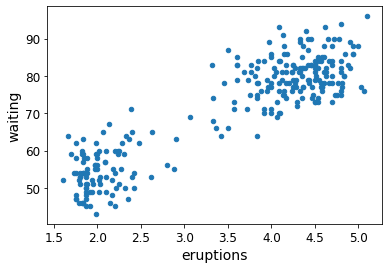

In [55]:
l0 = df.plot('eruptions', 'waiting', kind='scatter')

Claramente, no podremos ajustar esto con una normal.
Calculemos los valores de máxima verosimilitud para $\mu$ y $\Sigma$ usando los datos y veamos qué tal da.

Recordemos los resultados

$$
\mathbf{\mu}_\mathrm{ML} = \frac{1}{N}\sum_{n=1}^{N}\mathbf{x}_n \\
$$
$$
\mathbf{\Sigma}_\mathrm{ML} = \frac{1}{N}\sum_{n=1}^{N} (\mathbf{x}_n - \mathbf{\mu}_\mathrm{ML})(\mathbf{x}_n - \mathbf{\mu}_\mathrm{ML})^T
$$

Calculemos eso para los datos de Old Faithful

In [56]:
mu_ml = df.mean().to_numpy()

dx = (df - mu_ml)
sigma_ml = np.dot(dx.T, dx) / len(dx)

print(u'$\mu_ML$ = {}'.format(mu_ml))
print(u'$\Sigma_ML$ = {}'.format(sigma_ml))

$\mu_ML$ = [ 3.48778309 70.89705882]
$\Sigma_ML$ = [[  1.29793889  13.92641885]
 [ 13.92641885 184.14381488]]


Con estos valores, construyamos una binormal. Como no vamos a sacar valores al azar, usamos la implementación en <tt> scipy.stats</tt>.

In [57]:
import scipy.stats as st
p = st.multivariate_normal(mean=mu_ml, cov=sigma_ml)

Ahora viene la parte divertida. Vamos a graficar los contornos de la binormal sobre los datos de Old Faithful.

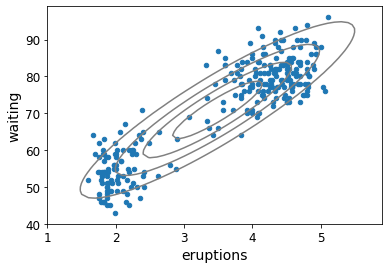

In [58]:
# Primero construyo una grilla de valores
x, y = np.mgrid[1.0:6.0:0.1, 40:100:1]
pos = np.dstack((x, y))

# Prepara figure
fig = plt.figure()
ax = fig.add_subplot(111)

# Vuelve a graficar datos grafica contornos (elegimos usar 4 contornos)
df.plot('eruptions', 'waiting', kind='scatter', ax=ax)
l0 = ax.contour(x, y, p.pdf(pos), 4, colors='0.5')

Claramente el modelo de una Gaussiana no es bueno. El modelo no solo no recoje el comportamiento bimodal de los datos, sino que además contiene mucha densidad en el centro entre ambos grupos de puntos.



### Un paréntesis

Podemos calcular la verosimulitud de estos puntos. Suponiendo que son independientes:

$$
p(D | \mu_\mathrm{ML}, \Sigma_\mathrm{ML}) = \prod_{n=1}^N \mathcal{N(\mathbf{x}_n | \mu_\mathrm{ML}, \Sigma_\mathrm{ML}})\;\;.
$$

Evaluo entonces la densidad de la distribución en cada punto y multiplico. Para eso, usamos la práctica función `apply` de Pandas

In [ ]:
densities = df.apply(p.pdf, axis=1)
print('La verosimilitud de este modelo es {}'.format(np.prod(densities)))

¿Qué pasó? Las densidades no son cero. Veamos:

In [ ]:
densities.head(10)

¿Alguna idea?

***

Nos encontramos con un problema típico cuando tratamos con muchos datos. La verosimilitud de cada uno de ellos es baja, y al multiplicarlos, llegamos por debajo del número más pequeño que puede representar la computadora. Este problema se hará más agudo cuantos más datos tengamos y cuanto mayor sea la dimensionalidad del espacio.

La solución es trabajar con el logaritmo de la verosimilitud.

En ese caso:

$$
\ln p(D | \mu_\mathrm{ML}, \Sigma_\mathrm{ML}) = \sum_{n=1}^N \ln \mathcal{N(\mathbf{x}_n | \mu_\mathrm{ML}, \Sigma_\mathrm{ML}}) = -\frac{1}{2}\sum_{n=1}^{n} \left[\ln(|\mathbf{\Sigma}|) + \ln(2\pi) + (\mathbf{x}_n - \mathbf{\mu}_\mathrm{ML})^T \mathbf{\Sigma}^{-1}(\mathbf{x}_n - \mathbf{\mu}_\mathrm{ML})\right]\;\;.
$$

Por suerte esto está implementado en <tt>scipy.stats</tt>.


In [ ]:
logdensities = df.apply(p.logpdf, axis=1)
print(logdensities.head())

In [ ]:
# Ahora solo hay que sumar
lnlike = np.sum(logdensities)
print(lnlike)

Fíjense que podríamos haber intentado directamente hacer el log de las densidades que ya teníamos; pero esto solo va a funcionar si la densidad de cada punto es (numéricamente) distinta de cero, lo cual no ocurrirá si el espacio tiene muchas dimensiones.

In [ ]:
lnlike2 = np.sum(np.log(densities))
print(lnlike2)

## Presentación del modelo

Este ejemplo muestra una de las limitaciones de un modelo normal: solo puede captar distribuciones con un único modo. Una forma de sobreponerse a este problema es usar un modelo que consista en una superposición de $K$ distribuciones normales.

$$
p(\mathbf{x}|\: \boldsymbol{\mu}, \boldsymbol{\Sigma}) = \sum_{k=1}^K \pi_k{\mathcal{N}(\mathbf{x} \:|\: \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)}\;\;,
$$
donde cada densidad $\mathcal{N}(\mathbf{x} \:|\: \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)$ se conoce como una *componente* de la mixtura, y tiene su propio valor medio y matriz de covarianza. Los $\pi_k$ son los *coeficientes* de mezcla.

### Los coeficientes como probabilidades

Integrando a ambos lados de la igualdad sobre todos los valores de $\mathbf{x}$ y viendo que tanto $p(\mathbf{x})$ como las componentes normales son funciones de distribución de probabilidad, llegamos a que

$$
\sum_{k=1}^K \pi_k = 1\;\;.
$$

Además, como $p(\mathbf{x})$ tienen que ser positiva, encontramos que una forma de garantizar eso de manera general es definir que los coeficientes sean positivos. Por lo tanto, $0 \leq \pi_k \leq 1$, y los coeficientes satisfacen los requerimientos para ser probabilidades.

Podemos, entonces, asignar una función de distribución de masa, $p(k)$, que describe la probabilidad (prior) de que se elija la compoenente $k$, y $p(k) = \pi_k$. Entonces, distribución sobre $\mathbf{x}$ queda:

$$
p(\mathbf{x}) = \sum_{k=1}^K p(\mathbf{x}, k) = \sum_{k=1}^K p(k) p(\mathbf{x} | k)\;\;,
$$

donde la probabilidad condicionada $p(\mathbf{x} | k) = \mathcal{N}(\mathbf{x} \:|\: \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)$.

En otras palabras, visto de esta manera, para muestrear el modelo de mixtura puede pensarse como una cadena, donde uno decide primero a qué modo pertence un punto y luego muestrea ese modo. Esto se llama muestreo ancestral. Veámoslo en acción.

In [ ]:
# Supongamos una distribución unidimensional de dos modos, con los siguientes parámetros
mu1 = [0.0,]
sigma1 = [2.0,]
mu2 = [5.0,]
sigma2 = [1.5,]

# Generemos las dos distris
n1 = st.norm(mu1, sigma1)
n2 = st.norm(mu2, sigma2)

# Ahora pensemos que tenemos una distribución prior p(k) con las siguientes elementos
p1 = 0.65
p2 = 0.35

# Veamos como podemos generar, fácilmente, muestras de la mixtura:
# p1 * N1 + p2 * N2
# Primero muestreo p(k)
N = 5000
k = np.where(np.random.rand(N) < p1, 1, 2)
# Para más modos, se puede hacer a mano, pero es más dificil. Mejor usar st.multinomial

# Y ahora lo combino con las mixturas

# Modo 1 (estricto)
# x1 = n1.rvs(sum(k==1), 1)
# x2 = n2.rvs(sum(k==2), 1)

# x = np.hstack([x1, x2])

# Modo 2 (generando de más)
x1 = n1.rvs(N, 1)
x2 = n2.rvs(N, 1)

x = np.where(k==1, x1, x2).reshape((-1, 1))

h = plt.hist(x, 50, histtype='step', density=True)

# Combinemos esto con la pdf del modelo
xx = np.linspace(x.min(), x.max(), 400)
plt.plot(xx, p1 * n1.pdf(xx) + p2 * n2.pdf(xx), 'r-')

In [ ]:
# Obviamente, como sabemos de dónde viene cada muestra, las podemos plotear por separado.
bins = h[1]
h = plt.hist(x, bins, histtype='step', lw=5, color='k', alpha=0.2)
h1 = plt.hist(x[k==1], bins, label='Componente 1', histtype='step')
h2 = plt.hist(x[k==2], bins, label='Componente 2', histtype='step')
plt.legend(loc=0)

Pero mantengamos en mente que en los problemas que vamos a resolver, contaremos con la distribución azul de la celda anterior y sin información sobre el origen de cada muestra. Es como si hubiéramos perdido el arreglo $\mathbf{k}$. Al conjunto de datos $\{\mathbf{x}, \mathbf{k}\}$ se lo llama dataset completo, y a $\mathbf{x}$ se lo conoce como dataset incompleto. 

Claro que nunca estuvo completo, en principio....

### Responsabilidades


Un rol crucial lo van a jugar las posteriores de la probabilidad de cada modo $p(k \:|\: \mathbf{x})$, que se conocen como *responsabilidades* (¡cuánta seriedad!)

$$
\gamma_k(\mathbf{x}) \equiv p(k \:|\: \mathbf{x})\;\;.
$$

Como es de esperar, podemos calcular la pinta que tienen las responsabilidades a partir del teorema de Bayes:

$$
\begin{eqnarray}
\gamma_k(\mathbf{x}) &=& \frac{p(k) p(\mathbf{x}\:|\:k)}{\sum_i p(i) p(\mathbf{x}\:|\:i)}\\
   &=&\frac{\pi_k{\mathcal{N}(\mathbf{x} \:|\: \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)}}{\sum_i{\pi_i{\mathcal{N}(\mathbf{x} \:|\: \boldsymbol{\mu}_i, \boldsymbol{\Sigma}_i)}}}\;\;,
\end{eqnarray}
$$
donde usamos la definición de arriba
$$
p(\mathbf{x}) = \sum_{k=1}^K \pi_k{\mathcal{N}(\mathbf{x} \:|\: \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)}\;\;.
$$

__Verosimilitud__ (o Donde arrancan los líos)

Naturalmente, necesitaremos poder escribir la verosimilitud para un modelo de este tipo. Como vimos arriba, el problema con las exponenciales de la normal, es que muchas veces generan problemas numéricos.

Vamos entonces a escribir el logaritmo de la verosimilitud, como ya hicimos un montón de veces.

$$
\ln p(\mathbf{X} \:|\: \boldsymbol{\mu}, \boldsymbol{\Sigma}, \boldsymbol{\pi}) = \sum_{n=1}^N \ln \left\{\sum_{k=1}^K \pi_k{\mathcal{N}(\mathbf{x}_n \:|\: \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)}\right\}\;\;,
$$
donde estamos usando esta notación: $\boldsymbol{\mu} \equiv \left\{\boldsymbol{\mu}_1, \ldots, \boldsymbol{\mu}_K\right\}$, y lo mismo para $\boldsymbol{\Sigma}$ y para $\boldsymbol{\pi}$. Y como siempre $\mathbf{X} = \left\{\mathbf{x}_1, \ldots, \mathbf{x}_N\right\}$.

Vemos que el logaritmo actúa sobre la sumatoria y no sobre cada normal de manera individual. Esto hace que sea complicado obtener una forma cerrada para los parámetros que maximizan la verosimilitud. Tenemos que usar un procedimiento iterativo, conocido como el algoritmo de maximización de la expectación, o *expectation maximisation* (EM).

### Variables latentes / ocultas

Para presentar de forma correcta el EM, primero tenemos que introducir un conjunto de nuevas variables, llamadas latentes. Más que un deseo de rigurosidad insaciable, nos mueve el hecho de que los modelos que tienen variables latentes suelen ser capaces de captar mucha complejidad de forma sencilla, y resultan una herramienta fundamental a la hora de modelar datos de la vida real. (**NB**: diría que, más allá de cualquier algoritmo particular que se puedan llevar de la materia, el concepto de las variables latentes y el truco del kernel son las dos herramientas más poderosas que presentamos; son como el martillo y el serrucho de un constructor de modelos). Vamos a ver enseguida que agrandar el problema y pensar en una distribución conjunta facilita la resolución del problema condicional, $p(\mathbf{x} \:|\: k)$, que presentamos más arriba.

Vamos a introducir una variable latente binaria, $K$-dimensional, $z$, con una representación 1-de-K. Es decir, todos los elementos son 0, excepto por el elemento $k$ que es uno y que indica a qué modo pertenece una determinada observación. Claramente, se verifica que $\sum_k z_k = 1$ (la suma de los elementos de la variable $z$ es uno).

Entonces, la relación con los coeficientes anteriores es:

$$
p(z_k = 1) = \pi_k\;\;,
$$
y podemos escribir la distribución del _vector_ $\mathbf{z}$ como

$$
p(\mathbf{z}) = \prod_{k=1}^K \pi_k^{z_k}\;\;.
$$

Además, la condicional

$$
p(\mathbf{x} \:|\: z_k = 1) = \mathcal{N}(\mathbf{x} \:|\: \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)
$$
también puede escribirse para el vector $\mathbf{z}$ de la misma manera
$$
p(\mathbf{x} \:|\: \mathbf{z}) = \prod_{k=1}^K \mathcal{N}(\mathbf{x} \:|\: \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)^{z_k}\;\;.
$$

Bien, podemos entonces, plantear el problema original en términos de las distribuciones conjuntas, condicionales y marginales, $p(\mathbf{x}, \mathbf{z})$, $p(\mathbf{x} \:|\: \mathbf{z})$ y $p(\mathbf{z})$, que, como sabemos desde la primera clase, se relacionan a través de la regla del producto:

$$
p(\mathbf{x}, \mathbf{z}) = p(\mathbf{x} \:|\: \mathbf{z}) p(\mathbf{z})\;\;,
$$
y también podemos marginalizar sobre las variables latentes para recuperar el modelo anterior:

$$
p(\mathbf{x} | \boldsymbol{\mu}, \boldsymbol{\Sigma}) = \sum_\mathbf{z} p(\mathbf{x} \:|\: \mathbf{z}) p(\mathbf{z}) = \sum_{k=1}^K \pi_k{\mathcal{N}(\mathbf{x} \:|\: \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)}\;\;.
$$

O sea, estoy hace media hora dándole vueltas a las ecuaciones para llegar a lo mismo. ¿O no? 
En principio, vean que para cada dato $n$ habrá una variable latente $\mathbf{z}_n$.

### El algoritmo EM


La gran ventaja de este planteo es que ahora podemos trabajar con la distribución conjunta $p(\mathbf{x}, \mathbf{z})$, que nos da pie para poner en marcha un algoritmo muy general, que sirva para todos los modelos que usen variables latentes. 

Acá vamos a presentarlo solo para las mixturas gaussianas. Pueden encontrar un tratamiento mucho más general en la Sect. 9.4 del Bishop.

Vamos a definir dos matrices, con los datos incompletos $\mathbf{X}$ y con las variables latentes $\mathbf{Z}$, cuya fila $n$ corresponde al vector de variables latentes del dato $\mathbf{x}_n$, $\mathbf{z}_n$.
Primero, volvamos a escribir el logaritmo de la verosimilitud, pero ahora del conjunto completo:
$$
\ln p(\mathbf{X}, \mathbf{Z} \:|\: \boldsymbol{\mu}, \boldsymbol{\Sigma}, \boldsymbol{\pi}) = \sum_{n=1}^N  \sum_{k=1}^K z_{nk} \left\{\ln  \pi_k + \ln{\mathcal{N}(\mathbf{x}_n \:|\: \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)}\right\}\;\;.
$$

Esta ecuación es mucho más fácil de maximizar. El problema es que no tenemos el valor de las variables latentes. Podemos, entonces usar su valor de expectación, que resulta

$$
\mathbb{E}(z_{nk}) = \gamma(z_{nk})\;\;,
$$

por lo que el valor expectación con respecto a las variables latentes es

$$
\mathbb{E}_Z[\ln p(\mathbf{X}, \mathbf{Z} \:|\: \boldsymbol{\mu}, \boldsymbol{\Sigma}, \boldsymbol{\pi})] = \sum_{n=1}^N  \sum_{k=1}^K \gamma(z_{nk}) \left\{\ln  \pi_k + \ln{\mathcal{N}(\mathbf{x}_n \:|\: \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)}\right\}\;\;.\;\;,
$$


Derivando con respecto a $\boldsymbol{\mu}_k$ e igualando a cero, tenemos:

$$
0 = \sum_{n=1}^N \gamma(z_{nk}) \Sigma_k^{-1} (\mathbf{x_n} - \boldsymbol{\mu}_k)\;\;.
$$

Multiplicando a ambos lados por $\Sigma_k$, llegamos a:

$$
\boldsymbol{\mu}_k = \frac{1}{N_k} \sum_{n=1}^N {\gamma(z_{nk}) \mathbf{x}_n}\;\;,
$$

con

$$
N_k = \sum_{n=1}^N {\gamma(z_{nk})}\;\;,
$$

que es una especie de número efectivo de muestras provenientes del modo $k$.

Lo mismo podemos hacer para la covarianza $\Sigma_k$ y da

$$
\boldsymbol{\Sigma}_k = \frac{1}{N_k} \sum_{n=1}^N {\gamma(z_{nk}) (\mathbf{x}_n - \boldsymbol{\mu}_k)(\mathbf{x}_n - \boldsymbol{\mu}_k)^T}\;\;,
$$

y para los coeficientes de mezcla, usando la condición (via multiplicadores de Lagrange) de que su suma tienen que ser uno.

$$
\pi_k = \frac{N_k}{N}\;\;.
$$

Hay que ver que la expresión para las medias y la covarianza tiene la misma pinta que para el caso de una sola distribución gaussiana. Pero como aparecen las responsabilidades, la forma no es cerrada.

Se vislumbra un proceso iterativo de la siguiente forma:

1. Se inicializan los parámetros $\boldsymbol{\mu}_k$, $\boldsymbol{\Sigma}_k$, y $\pi_k$.

2. Se calculan las responsabilidades para esos valores de los parámetros (paso E).

3. Con las nuevas responsabilidades, se recalculan los parámetros que maximizan la verosimilitud (paso M). Como antes, podemos actualizar las medias antes de calcular el nuevo valor de las covarianzas.

4. Volver a calcular el logaritmo de la verosimilitud.

5. Evaluar algún criterio de detención, sea en LogL o en los parámetros.

Vamos a ver cómo funciona con nuestro set unidimensional. `sklearn` tiene implementado el algo EM en la clase `
mixture.GaussianMixture`

In [ ]:
from sklearn.mixture import GaussianMixture

# Veamos la docu
GaussianMixture?

In [ ]:
# gm = GaussianMixture(2, means_init=np.array([0.0, 5.0]).reshape(2, 1), weights_init=[0.5, 0.5], tol=1e-8)
gm = GaussianMixture(2, tol=1e-8)
gm.fit(x)

print('Fitted parameters')
print('Mixing coeff:', gm.weights_.flatten())
print('Means:', gm.means_.flatten())
print('widhts:', np.sqrt(gm.covariances_).flatten())

print('')

# Recordemos los parámetros
print('Parámetros Gound Truth')
print('Mixing coeff: {}, {}'.format(p1, p2))
print('Means:', np.array([n1.args[0], n2.args[0]]).flatten())
print('widhts:',  np.array([n1.args[1], n2.args[1]]).flatten())

Nada mal. Comparemos ahora con la densidad real. Esta clase de `sklearn` tiene un método, `score_samples`, que hace exactamente eso.

In [ ]:
# Comparemos con la densidad real
plt.plot(xx, p1 * n1.pdf(xx) + p2 * n2.pdf(xx), 'r-', label='Truth', lw=5, alpha=0.4)
plt.plot(xx, np.exp(gm.score_samples(xx.reshape(-1, 1))), label='ML fit', color='k')
plt.legend(loc=0)

En esta clase, las predicciones son sobre el modo al que pertenece cada punto. 

Es un modelo de clasificación generativo __no supervisado__! Veamos que tan bien funciona.

In [ ]:
y = gm.predict(x)

# Preparemos un vector de labels con valores {0, 1} en lugar de {1, 2}.
t = np.where(k==1, 1, 0)

from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve
print('Accuracy: {:.2f}'.format(accuracy_score(t, y)))
print('Precision: {:.2f}'.format(precision_score(t, y)))
print('Recall: {:.2f}'.format(recall_score(t, y)))

In [ ]:
y = gm.predict(x)
print(y)

In [ ]:
# Algo un poco más robusto sería con cross val predict
from sklearn.model_selection import cross_val_predict
y = cross_val_predict(gm, x, t, cv=5)

from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve
print('Accuracy: {:.2f}'.format(accuracy_score(t, y)))
print('Precision: {:.2f}'.format(precision_score(t, y)))
print('Recall: {:.2f}'.format(recall_score(t, y)))

In [ ]:
# Probas de cada clase
probas = gm.predict_proba(x)

# Tenemos que elegir una de las clases como la positiva
p, r, th = precision_recall_curve(t, probas[:, 1])
plt.figure(figsize=(9, 6))
plt.plot(th, p[:-1], lw=2, alpha=0.8, label='Precision')
plt.plot(th, r[:-1], lw=2, alpha=0.8, label='Recall')
plt.legend(loc=0, fontsize=14)

### Revisitamos a Old Faithful

Ahora a ustedes. Tomen el dataset de Old Faithful de acá arriba y ajusten un modelo de mixtura. Usen la clase de `sklearn`.

Después copien el código que está arriba para plotear los contornos.

In [ ]:
gm = GaussianMixture(2, tol=1e-3)
gm.fit(df)

print('Fitted parameters')
print('Mixing coeff:', gm.weights_)
print('Means:\n', gm.means_)
print()
print('Covariances:\n', gm.covariances_)

In [ ]:
# Primero construyo una grilla de valores
x, y = np.mgrid[1.0:6.0:0.1, 40:100:1]
pos = pos = np.dstack((x, y))

# Compute mixture pdf

# Usando sklearn
X_ = np.c_[x.ravel(), y.ravel()]

# Calculo la clase
clase1d = gm.predict(X_)
clase2d = clase1d.reshape(x.shape)

# Calculo la densidad
pdf = np.exp(gm.score_samples(X_))
P = pdf.reshape(x.shape)

# "A mano"
# P = (gm.weights_[0] * st.multivariate_normal.pdf(pos, mean=gm.means_[0], cov=gm.covariances_[0]) +
#        gm.weights_[1] * st.multivariate_normal.pdf(pos, mean=gm.means_[1], cov=gm.covariances_[1]))

In [ ]:
# Prepara figure
fig = plt.figure()
ax = fig.add_subplot(111)

# Vuelve a graficar datos y densidad
l0 = ax.contourf(x, y, P, 256, alpha=1)
df.plot('eruptions', 'waiting', kind='scatter', ax=ax, c='w', alpha=0.4)

In [ ]:
# Prepara figure
fig = plt.figure()
ax = fig.add_subplot(111)

# Vuelve a graficar datos y clases
l0 = ax.contourf(x, y, clase2d, alpha=1)
df.plot('eruptions', 'waiting', kind='scatter', ax=ax, c=gm.predict(df), alpha=0.8)

In [ ]:
# Predicción de clase para un nuevo dato y su responsabilidad.
x_nuevo = np.array([3.0, 65.0]).reshape(1, 2)
print(gm.predict(x_nuevo))
print(gm.predict_proba(x_nuevo))

In [ ]:
# Marginalizamos uno de los features (la duración de la erupción).

xx = np.linspace(40, 100, 200)

scale1 = np.sqrt(gm.covariances_[0][1,1])
scale2 = np.sqrt(gm.covariances_[1][1,1])

pp = (gm.weights_[0] * st.norm.pdf(xx, loc=gm.means_[0][1], scale=scale1) + 
      gm.weights_[1] * st.norm.pdf(xx, loc=gm.means_[1][1], scale=scale2))

plt.plot(xx, pp)
plt.xlabel('waiting')

In [ ]:
# Nos quedamos con una única componente
k = 1

# No vale la pena incluir el coeficiente, porque después hay que normalizar
pp = st.multivariate_normal.pdf(pos, mean=gm.means_[k], cov=gm.covariances_[k])

l0 = plt.contourf(x, y, pp, alpha=1)
#plt.colorbar(l0)
#df.plot('eruptions', 'waiting', kind='scatter', ax=ax, c='w', alpha=0.3)

# Bonus track: K-means

Es un algoritmo de clustering que funciona minimizando la distancia de los puntos a los centros de los clusters.

Veamos su funcionamiento con los datos de Old Faithful

In [ ]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=2)
km.fit(df)

In [ ]:
# Veamos los parámetros
km.cluster_centers_

In [ ]:
plt.scatter(df.eruptions, df.waiting, c=km.labels_)
plt.plot(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], 'or', markersize=10)